In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
import json
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import random
import time
from tqdm import tqdm  # Progress bar
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('punkt')  # for word_tokenize
nltk.download('omw-1.4')  # for lemmatization
nltk.download('wordnet')  # for WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Jamie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Start timer
start_time = time.time()

lemmatizer = WordNetLemmatizer()

# Load intents
print("Loading intents...")
with open('data/intents_new.json', 'r', encoding='utf-8') as file:
    intents = json.load(file)

# Initialize data structures
words = []
classes = []
documents = []
ignore_words = ['?', '!', '.']

# Tokenize and process dataset
print("Processing data...")
for intent in intents['intents']:
    for pattern in intent['patterns']:  # Full dataset
        w = nltk.word_tokenize(pattern)
        words.extend(w)
        documents.append((w, intent['tag']))
        if intent['tag'] not in classes:
            classes.append(intent['tag'])

# Lemmatize, sort, and remove duplicates
print("Lemmatizing words...")
words = sorted(set([lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words]))
classes = sorted(set(classes))

print(f"Total unique words: {len(words)}")
print(f"Total classes: {len(classes)}")

# Create training data
print("Creating training data...")
training = []
output_empty = [0] * len(classes)

for doc in tqdm(documents, desc="Processing documents"):
    bag = [1 if w in [lemmatizer.lemmatize(word.lower()) for word in doc[0]] else 0 for w in words]
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    training.append([bag, output_row])

random.shuffle(training)
training = np.array(training, dtype=object)

# Split into training & testing sets
train_x, test_x, train_y, test_y = train_test_split(
    np.array(list(training[:, 0])), np.array(list(training[:, 1])), test_size=0.2, random_state=42
)

print(f"Training samples: {len(train_x)}, Testing samples: {len(test_x)}")
print(f"Preprocessing completed in {time.time() - start_time:.2f} seconds.")

Loading intents...
Processing data...
Lemmatizing words...
Total unique words: 582
Total classes: 80
Creating training data...


Processing documents: 100%|██████████| 2045/2045 [00:22<00:00, 90.61it/s] 


Training samples: 1636, Testing samples: 409
Preprocessing completed in 25.02 seconds.


In [83]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from keras.regularizers import l1_l2, l2
import numpy as np

# Compute class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(np.argmax(train_y, axis=1)),
    y=np.argmax(train_y, axis=1)
)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
num_classes = len(np.unique(np.argmax(train_y, axis=1)))  

# Build the model
print("Building model...")
model = Sequential([
    Dense(128, input_shape=(len(train_x[0]),), activation='relu', kernel_regularizer=l2(0.0001)),  # Reduced neurons + L2
    BatchNormalization(),
    Dropout(0.5),  # Increased Dropout,
    Dense(64, activation='relu', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile the model with a slightly higher learning rate
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0005), metrics=['accuracy'])
model.summary()

# Callbacks for early stopping and saving the best model
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('models/chatbot_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model
print("Training model...")
history = model.fit(train_x, train_y, epochs=500, batch_size=32, verbose=1, 
                    validation_data=(test_x, test_y), class_weight=class_weight_dict, 
                    callbacks=[early_stop, checkpoint])

print("Model training completed.")


Building model...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 128)               74624     
                                                                 
 batch_normalization_18 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_19 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 

In [84]:
# Print model summary with input/output shapes
model.summary()

# Print detailed layer-wise input and output shapes
for layer in model.layers:
    print(f"Layer: {layer.name}")
    print(f"    Input Shape: {layer.input_shape}")
    print(f"    Output Shape: {layer.output_shape}\n")


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 128)               74624     
                                                                 
 batch_normalization_18 (Bat  (None, 128)              512       
 chNormalization)                                                
                                                                 
 dropout_18 (Dropout)        (None, 128)               0         
                                                                 
 dense_28 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_19 (Bat  (None, 64)               256       
 chNormalization)                                                
                                                                 
 dropout_19 (Dropout)        (None, 64)               

In [85]:
# Save words and classes to pickle files
pickle.dump(words, open('pkl/words.pkl', 'wb'))
pickle.dump(classes, open('pkl/classes.pkl', 'wb'))
print("Words and classes saved to pickle files.")

# Save training history
with open('models/training_history.json', 'w') as f:
    json.dump(history.history, f)
print("✅ Model training completed and saved!")

Words and classes saved to pickle files.
✅ Model training completed and saved!


Final Training Accuracy: 0.9438
Final Training Loss: 0.2593
Final Validation Accuracy: 0.8826
Final Validation Loss: 0.4943
Best Epoch: 64
Best Training Accuracy: 0.9199
Best Training Loss: 0.3600
Best Validation Accuracy: 0.8802
Best Validation Loss: 0.4854


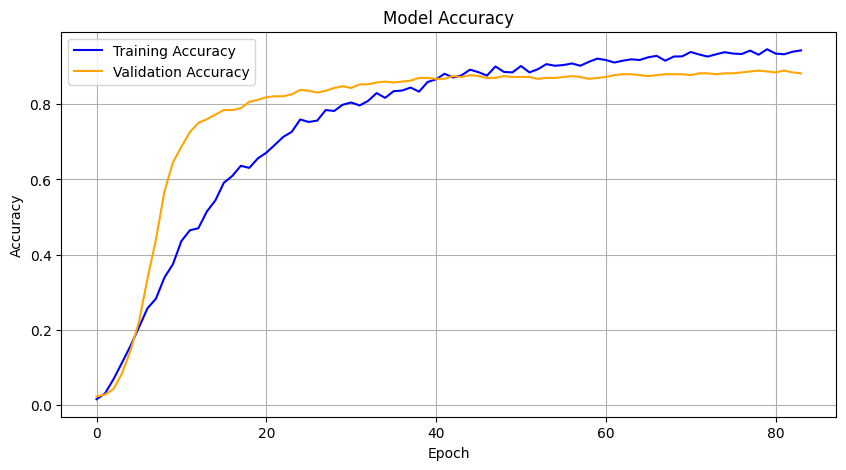

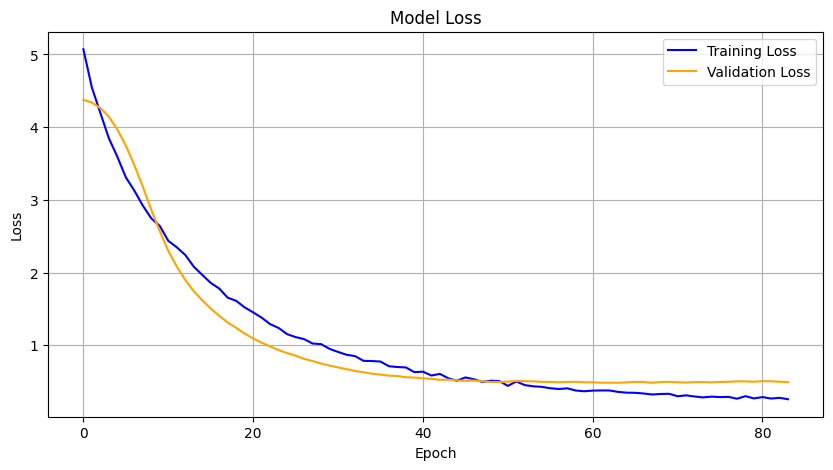

In [86]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
# Print final training and validation metrics
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

best_epoch = np.argmin(history.history['val_loss'])  # Get the epoch with the lowest val_loss
print(f"Best Epoch: {best_epoch+1}")
print(f"Best Training Accuracy: {history.history['accuracy'][best_epoch]:.4f}")
print(f"Best Training Loss: {history.history['loss'][best_epoch]:.4f}")
print(f"Best Validation Accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
print(f"Best Validation Loss: {history.history['val_loss'][best_epoch]:.4f}")


# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

13/13 [==============================] - 0s 750us/step


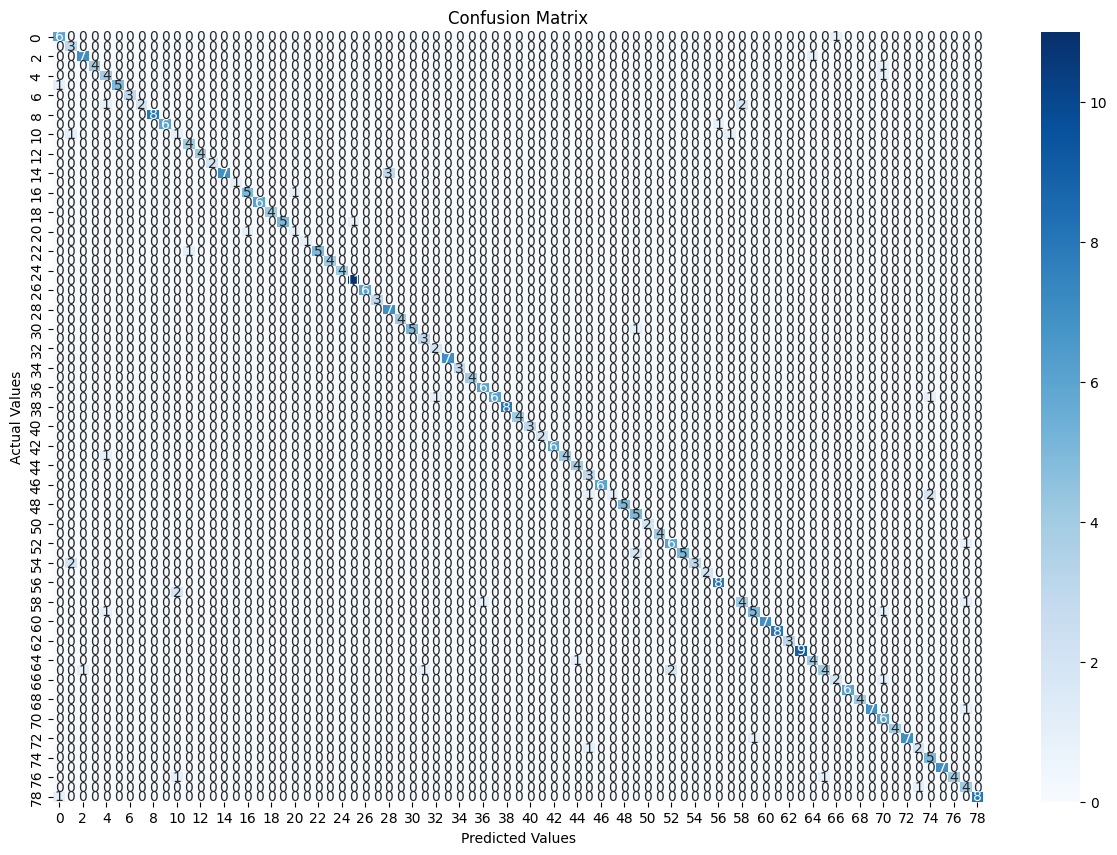

In [87]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

#Predict classes for test set
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)

#Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

#visualize using seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [88]:
# Get predictions on the test set
y_pred = model.predict(test_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)

# Ensure that the number of unique predicted classes matches the actual classes
print(f"Classes in the model: {len(classes)}")
print(f"Unique predicted labels: {len(np.unique(y_pred_classes))}")
print(f"Unique true labels: {len(np.unique(y_true))}")

# Classification report (precision, recall, f1-score) with the 'labels' parameter
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=classes, labels=np.unique(y_true)))

# Confusion matrix (helpful for seeing misclassifications)
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

print("Confusion Matrix:")
for row in cm:
    print(" ".join(map(str, row)))  # Joins values in each row with spaces

13/13 [==============================] - 0s 2ms/step
Classes in the model: 80
Unique predicted labels: 79
Unique true labels: 79
Classification Report:
                     precision    recall  f1-score   support

              about       0.75      0.86      0.80         7
          afternoon       0.50      1.00      0.67         3
            anxious       0.88      0.88      0.88         8
                ask       1.00      0.80      0.89         5
             casual       0.57      0.80      0.67         5
           creation       1.00      0.83      0.91         6
              death       1.00      1.00      1.00         3
            default       1.00      0.40      0.57         5
          depressed       1.00      1.00      1.00         8
               done       1.00      0.86      0.92         7
            evening       0.25      0.33      0.29         3
             fact-1       0.80      1.00      0.89         4
            fact-10       1.00      1.00      1.00    

c:\Users\Jamie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:2642: UserWarning: labels size, 79, does not match size of target_names, 80
  warnings.warn(


In [89]:
# Ensure correct conversion from softmax outputs
y_pred = model.predict(test_x)  # Get probabilities
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert to class indices
y_true = np.argmax(test_y, axis=1)  # Convert true labels

# Debug: Print expected vs actual class counts
print(f"Total Classes in Model: {len(classes)}")
print(f"Unique True Labels: {len(set(y_true))}")
print(f"Unique Predicted Labels: {len(set(y_pred_classes))}")

# Check which classes are actually missing
predicted_classes_set = set(y_pred_classes)
true_classes_set = set(y_true)

missing_classes_in_preds = true_classes_set - predicted_classes_set  # Classes present in y_true but never predicted
print(f"Classes Never Predicted: {[classes[i] for i in missing_classes_in_preds]}")


13/13 [==============================] - 0s 1ms/step
Total Classes in Model: 80
Unique True Labels: 79
Unique Predicted Labels: 79
Classes Never Predicted: []


In [90]:
import numpy as np
import pickle
import json
import nltk
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load necessary files
lemmatizer = WordNetLemmatizer()
model = load_model('models/chatbot_model.keras')

# Load words and classes
words = pickle.load(open('pkl/words.pkl', 'rb'))
classes = pickle.load(open('pkl/classes.pkl', 'rb'))

def preprocess_input(sentence):
    """ Tokenize and create a bag of words for the input sentence """
    sentence_words = nltk.word_tokenize(sentence)
    sentence_words = [lemmatizer.lemmatize(word.lower()) for word in sentence_words]

    # Create a bag of words array
    bag = [1 if w in sentence_words else 0 for w in words]
    return np.array([bag])  # Model expects batch input

def predict_intent(sentence):
    """ Predict the intent tag from a user input """
    bow = preprocess_input(sentence)  # Convert input to bag of words
    prediction = model.predict(bow)  # Make prediction
    
    predicted_class_index = np.argmax(prediction)  # Get the highest probability class index
    predicted_intent = classes[predicted_class_index]  # Map index to intent tag
    
    return predicted_intent

# Example usage
user_input = "casual"
intent = predict_intent(user_input)
print(f"Predicted Intent: {intent}")


1/1 [==============================] - 0s 59ms/step
Predicted Intent: casual
